In [8]:
import pandas as pd
from nixtla import NixtlaClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os


import warnings 
warnings.filterwarnings("ignore")


In [9]:
load_dotenv()

True

In [10]:
# Setup NixtlaClient
timegpt_api_key = os.getenv("NIXTLA_API_KEY")
nixtla_client = NixtlaClient(api_key=timegpt_api_key)

print("Nixtla Client initialized successfully!")

Nixtla Client initialized successfully!


In [11]:
import yfinance as yf


# Specify the cryptocurrency ticker
crypto_ticker = 'BTC-USD'
crypto_data = yf.download(crypto_ticker)


# Resetting the index and limiting the data
crypto_data = crypto_data.reset_index()
crypto_data = crypto_data.tail(1000)


# Displaying the dataset
crypto_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
2743,2022-03-22,42358.808594,42358.808594,43124.707031,40948.281250,41074.105469,32004652376
2744,2022-03-23,42892.957031,42892.957031,42893.507812,41877.507812,42364.378906,25242943069
2745,2022-03-24,43960.933594,43960.933594,44131.855469,42726.164062,42886.652344,31042992291
2746,2022-03-25,44348.730469,44348.730469,44999.492188,43706.285156,43964.546875,30574413034
2747,2022-03-26,44500.828125,44500.828125,44735.996094,44166.273438,44349.859375,16950455995


In [18]:
crypto_data.columns = crypto_data.columns.get_level_values(0)


In [19]:
# Displaying the dataset
crypto_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
2743,2022-03-22,42358.808594,42358.808594,43124.707031,40948.281250,41074.105469,32004652376
2744,2022-03-23,42892.957031,42892.957031,42893.507812,41877.507812,42364.378906,25242943069
2745,2022-03-24,43960.933594,43960.933594,44131.855469,42726.164062,42886.652344,31042992291
2746,2022-03-25,44348.730469,44348.730469,44999.492188,43706.285156,43964.546875,30574413034
2747,2022-03-26,44500.828125,44500.828125,44735.996094,44166.273438,44349.859375,16950455995


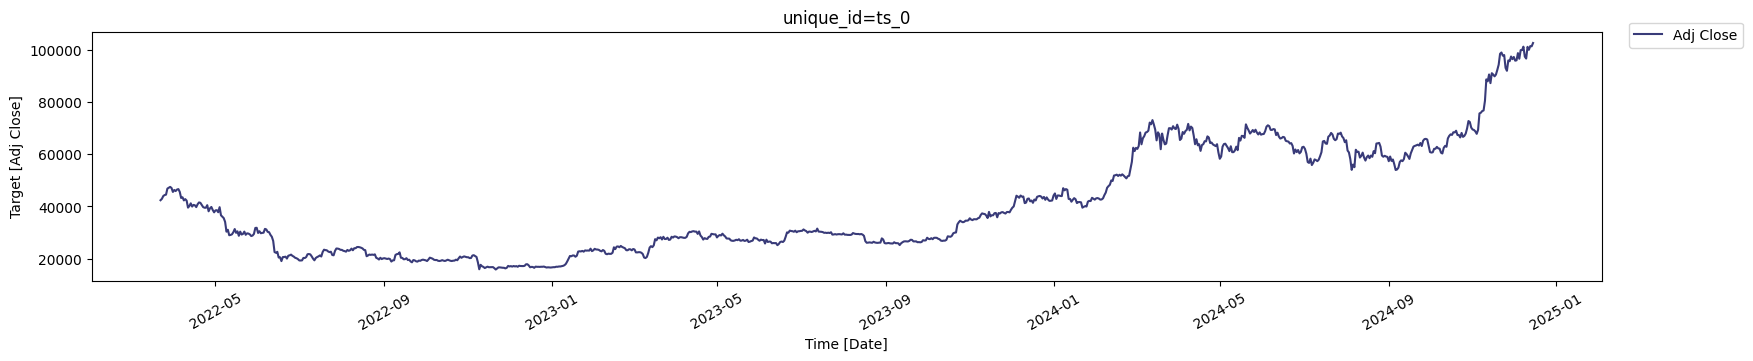

In [20]:
nixtla_client.plot(crypto_data, time_col='Date', target_col='Adj Close')

In [23]:
from utilsforecast.preprocessing import fill_gaps

In [27]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 2743 to 3742
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1000 non-null   datetime64[ns]
 1   Adj Close  1000 non-null   float64       
 2   Close      1000 non-null   float64       
 3   High       1000 non-null   float64       
 4   Low        1000 non-null   float64       
 5   Open       1000 non-null   float64       
 6   Volume     1000 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 54.8 KB


In [31]:
crypto_data.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [32]:
crypto_data['unique_id'] = 'id1'
crypto_data = crypto_data[['unique_id', 'ds', 'y']]

In [33]:
crypto_data = fill_gaps(crypto_data, freq='D')

In [36]:
crypto_forecast = nixtla_client.forecast(
    df=crypto_data,
    model="timegpt-1",
    h=12,
    freq="D",
    time_col="ds",
    target_col="y",
)
crypto_forecast.tail()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
7,id1,2024-12-23,98060.164
8,id1,2024-12-24,97916.540
9,id1,2024-12-25,101808.750
10,id1,2024-12-26,102315.390
11,id1,2024-12-27,102451.280


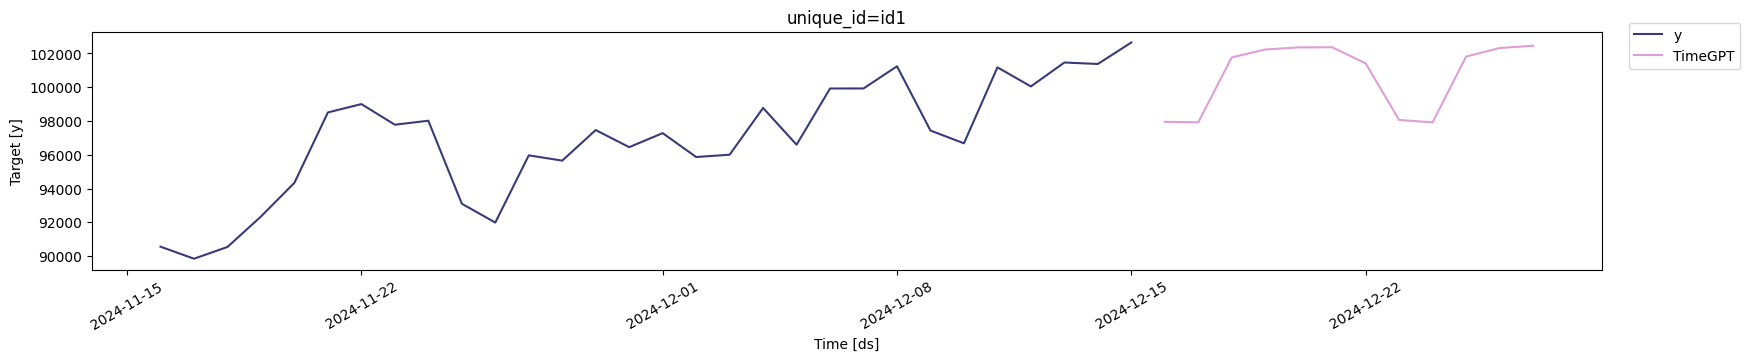

In [37]:
nixtla_client.plot(
    crypto_data,
    crypto_forecast,
    time_col="ds",
    target_col="y",
    max_insample_length=30,
)

In [39]:
crypto_data_forecast = nixtla_client.forecast(
    df=crypto_data,
    model="timegpt-1",
    h=12,
    level=[90],  # Generate a 90% confidence interval
    finetune_steps=120,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Specify the loss function for fine-tuning
    freq="D",
    time_col="ds",
    target_col="y",
    add_history=True
)
crypto_data_forecast.tail()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
973,id1,2024-12-23,101368.266,104031.290,98705.240
974,id1,2024-12-24,101466.160,104451.740,98480.570
975,id1,2024-12-25,103022.266,107129.370,98915.164
976,id1,2024-12-26,102908.875,106659.210,99158.540
977,id1,2024-12-27,103315.336,107842.375,98788.300


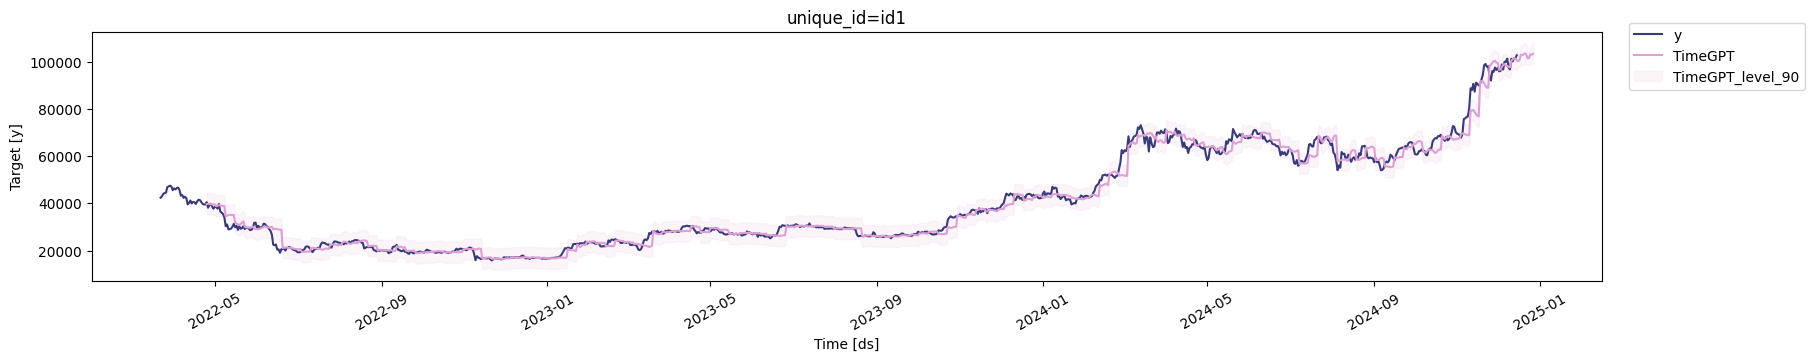

In [40]:
nixtla_client.plot(
    crypto_data,
    crypto_data_forecast,
    models=["TimeGPT"],
    level=[90],
    time_col="ds",
    target_col="y",
)

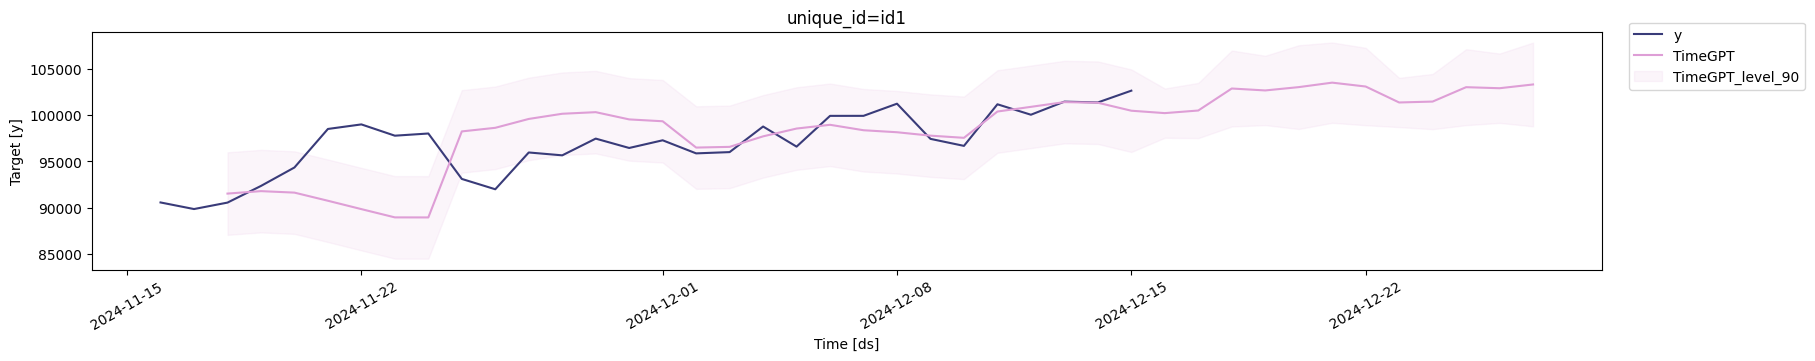

In [41]:
nixtla_client.plot(
    crypto_data.tail(30),
    crypto_data_forecast.tail(40),
    models=["TimeGPT"],
    level=[90],
    time_col="ds",
    target_col="y",
)

## TimeGPT Model Evaluation 
 

In [44]:
test_df = crypto_data.tail(120)
train_df = crypto_data.iloc[0:-120]


forecast_df = nixtla_client.forecast(
    df=train_df,
    h=120,
    level=[90],  # Generate a 90% confidence interval
    finetune_steps=120,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Use the MAE as the loss function for fine-tuning
    model="timegpt-1",  # Use the model for long-horizon forecasting
    time_col="ds",
    freq="D",
    target_col="y",
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [45]:
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])
test_df = pd.merge(test_df, forecast_df, "left", ["ds"])
evaluation = evaluate(
    test_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col="y",
)

average_metrics = evaluation.groupby("metric")["TimeGPT"].mean()
average_metrics

metric
mae      14266.888249
rmse     14266.888249
smape        0.096909
Name: TimeGPT, dtype: float64

In [42]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=12, freq='MS', time_col='Date', target_col='Close')
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...


ValueError: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.

In [ ]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')